# DC resistivity forward modelling to determine detectability of fault offset: A case study of two sites in the Fraser Canyon: Phase 1
_Raul Benjamin Mendoza_

In this notebook, I aim to use _discretize_ and _SimPEG_ to replicate the results I attained from inverting field data using EarthImager:
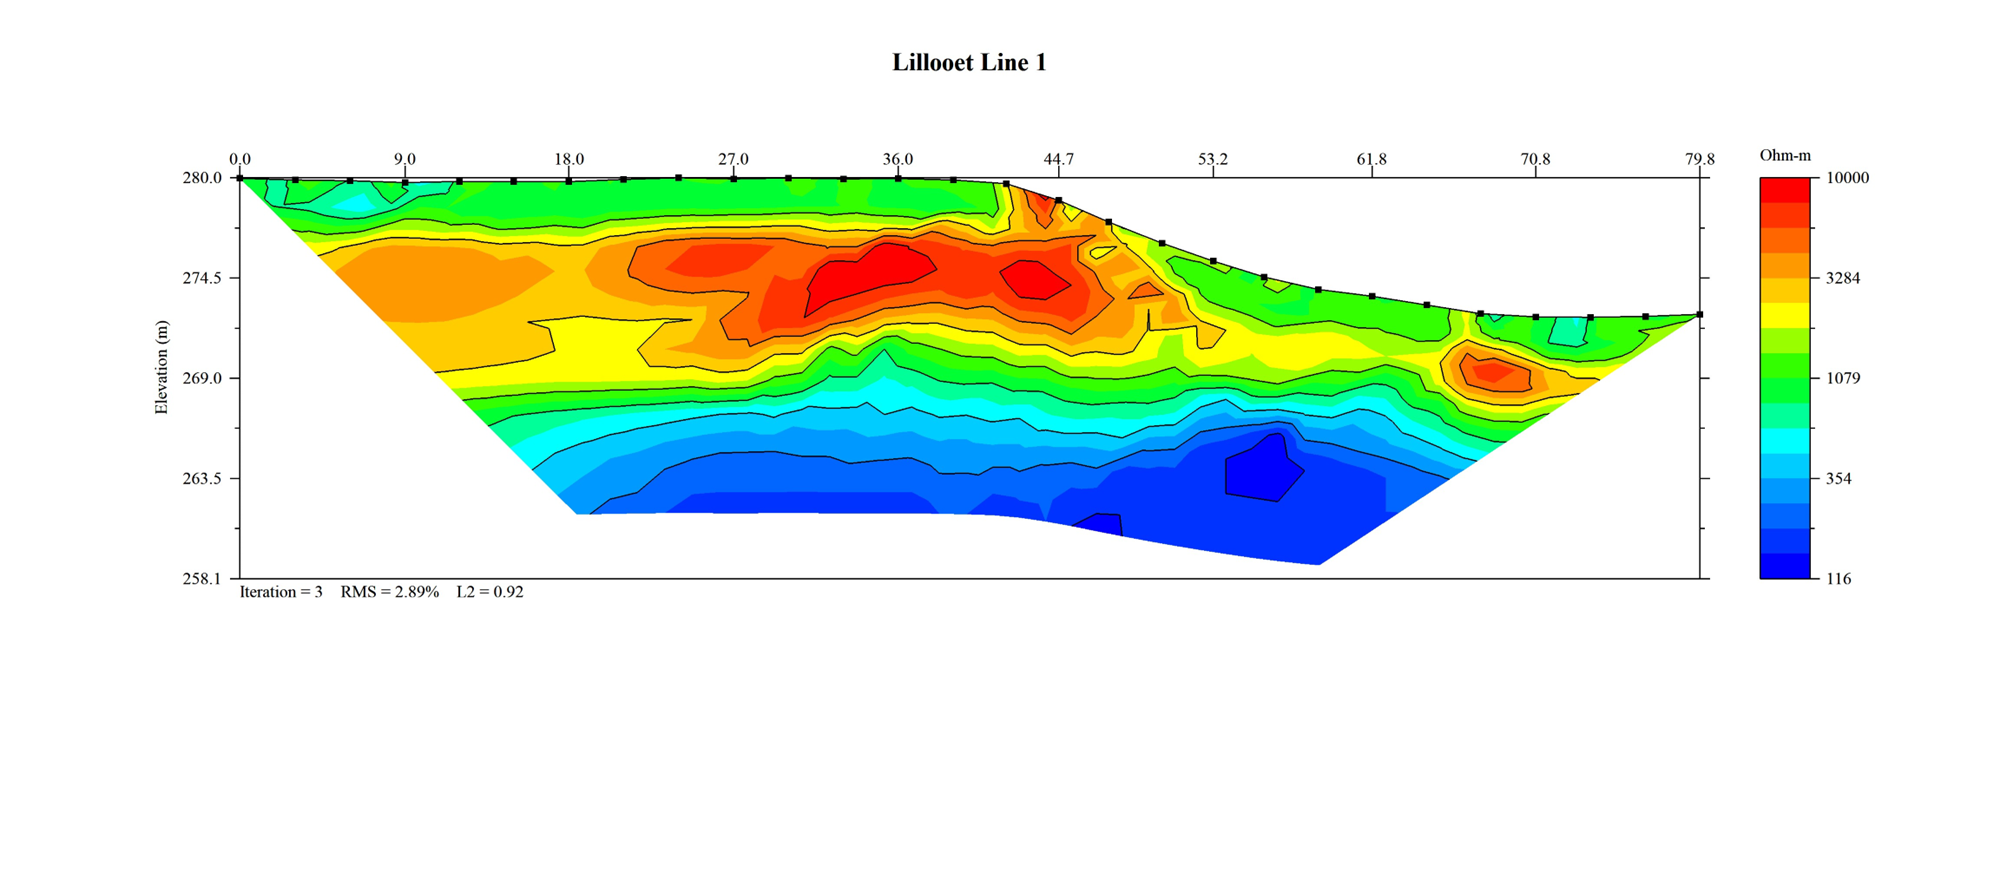

For now, this notebook loosely follows the SimPEG 2.5D DC Resistivity forward modelling and inversion tutorial notebooks (https://simpeg.xyz/user-tutorials/fwd-dcr-2d & https://simpeg.xyz/user-tutorials/inv-dcr-2d). 

## Import packages for forward modelling

In [1]:
# SimPEG functionality
import simpeg
from simpeg.electromagnetics.static import resistivity as dc
from simpeg.utils import model_builder
from simpeg import maps, data
from simpeg.electromagnetics.static.utils.static_utils import (
    write_dcip2d_ubc,
    pseudo_locations,
    plot_pseudosection,
    apparent_resistivity_from_voltage,
    generate_survey_from_abmn_locations,
    geometric_factor
)

# discretize functionality
from discretize import TreeMesh
from discretize.utils import active_from_xyz

# Common Python functionality
import os
import numpy as np
from scipy.interpolate import interp1d
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pandas as pd

# Functions specific to this project
from project_functions import (
    create_topography_from_terrain_file,
    plot_topography_from_dataframe,
    extract_survey_and_data_from_stg,
    plot_survey,
    create_mesh_from_survey,
    plot_mesh_and_survey,
    plot_model_on_survey_and_mesh,
    plot_normalized_volts_and_apparent_resistivity,
    create_data_object,
    save_model_to_txt,
    load_model_from_txt,
    plot_initial_and_recovered_models)

mpl.rcParams.update({"font.size": 14})  # default font size

## Create Survey object

### Define topography 
Use create_topography_from_terrain_file function.

In [2]:
TERRAIN_FILE_COLUMN_NAMES = ['x','z']
TERRAIN_FILE_PATH = './fieldData/Terrain_Line1_3m_Aug26_2024.trn'

topography_2d = create_topography_from_terrain_file(terrain_file_path=TERRAIN_FILE_PATH,
                                                    terrain_file_column_names=TERRAIN_FILE_COLUMN_NAMES)

# plot_topography_from_dataframe(topography_2d)

### Generate Survey object
Use the topography data and the raw .stg data file.

In [3]:
STG_FILEPATH = './fieldData/3m_Texas_Creek_line1_2024.stg'

survey, field_VI, field_Ohmm, field_error, sorting_indices = extract_survey_and_data_from_stg(
    topography_2d=topography_2d,
    stg_filepath=STG_FILEPATH,
    datatype='volt'
    )

# Check survey
attributes = vars(survey)
for att, value in attributes.items():
    print(f"{att}: {value}")

# plot_survey(survey)

Note: If you see 'UserWarning: Ordering of ABMN locations changed when generating survey,' you may disregard it 
because the extract_survey_and_data_from_stg function sorts the data for you. To compare the survey and sorted data 
with the unsorted data, this function also returns the sorting_indices array that was used to sort the raw data. 

_source_list: [Dipole(a: [  3.01915289 279.839     ]; b: [  0.    279.927]), Dipole(a: [  6.01871657 279.798     ]; b: [  3.01915289 279.839     ]), Dipole(a: [  9.01509641 279.704     ]; b: [  6.01871657 279.798     ]), Dipole(a: [ 11.97617521 279.76      ]; b: [  9.01509641 279.704     ]), Dipole(a: [ 14.95739276 279.755     ]; b: [ 11.97617521 279.76      ]), Dipole(a: [ 17.96085236 279.75      ]; b: [ 14.95739276 279.755     ]), Dipole(a: [ 20.95405883 279.866     ]; b: [ 17.96085236 279.75      ]), Dipole(a: [ 23.95254155 279.964     ]; b: [ 20.95405883 279.866     ]), Dipole(a: [ 26.95847823 279.897     ]; b: [ 23.95254155 279.964     ]), Di

c:\GitSpaces\eosc-556b-project\project_functions.py:164: UserWarning: Ordering of ABMN locations changed when generating survey. Associated data vectors will need sorting. Set output_sorting to True for sorting indices.
  survey, sorting_indices = generate_survey_from_abmn_locations(locations_a=locations_a, locations_b=locations_b,


## Create Mesh object

In [4]:
mesh, active_cells = create_mesh_from_survey(survey=survey, base_cell_size=0.75, padding_configuration=[15,10,1,1,1])

Base cell size: 0.75 m
padding_cells_by_level parameter: [15, 10, 1, 1, 1]
# of cells: 3668
# of nodes: 3882
Max cell volume: 576.0 sq.m.


## Modify Survey object to fit the mesh

<Axes: title={'center': 'Mesh and survey setup'}, xlabel='x [m]', ylabel='elevation [m]'>

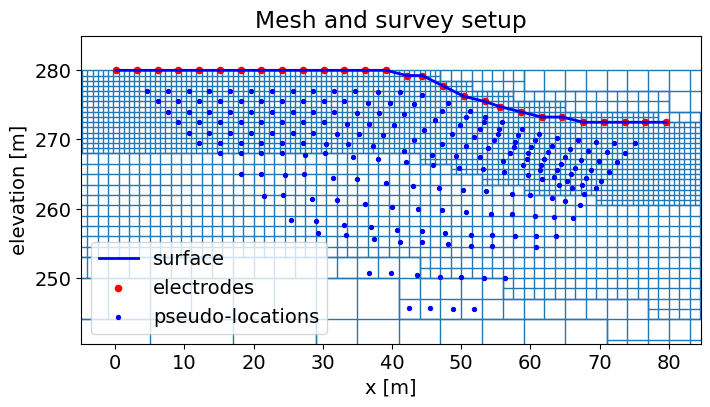

In [5]:
# Drape electrodes on topography to ensure none of them are "floating" in the air
survey.drape_electrodes_on_topography(mesh, active_cells, option="top")
# Geometric factor is needed to convert from measured normalized voltages to apparent resistivities
survey.set_geometric_factor(space_type='half-space')

# Plot the modified survey on the mesh
plot_mesh_and_survey(mesh=mesh, survey=survey)

## Create the hypothetical "true" model

### Define material resistivities

In [6]:
# Define resistivity values of different materials
AIR_LOGRESISTIVITY = np.log(1e+8)
MUD_LOGRESISTIVITY = np.log(1e+2)
SAND_LOGRESISTIVITY = np.log(1e+3)
GRAVEL_LOGRESISTIVITY = np.log(1e+4)

### Assign materials to different blocks
Attempt to replicate this:

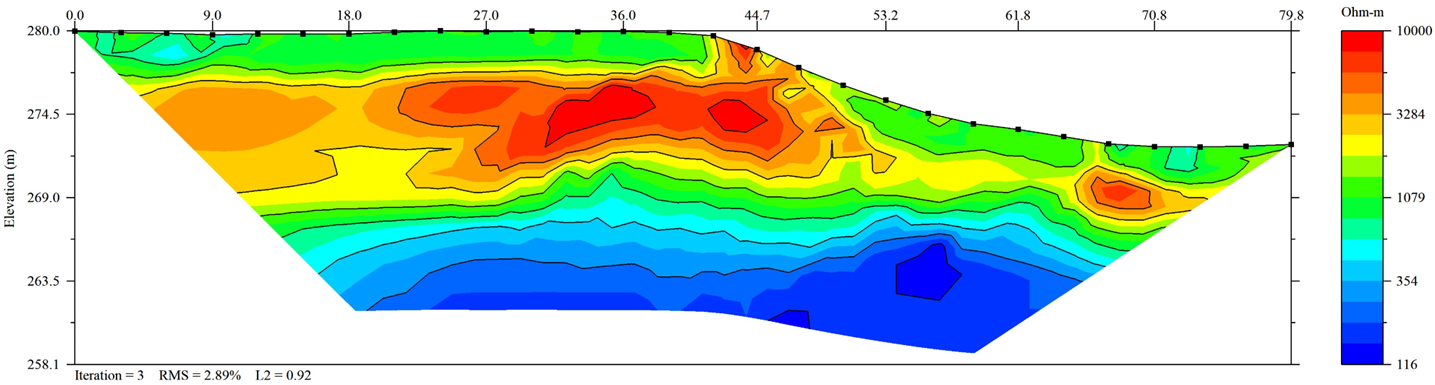

In [ ]:
# number of active cells
number_of_active_cells = np.sum(active_cells)

# UNFAULTED MODEL
# # Define background resistivity model as sand.
# logresistivity_model_unfaulted = SAND_LOGRESISTIVITY *np.ones(number_of_active_cells)
starting_logresistivity_model = SAND_LOGRESISTIVITY *np.ones(number_of_active_cells)

# # Add units of different resistivities
# ind_gravel = model_builder.get_indices_block(np.r_[-40,271],np.r_[48,276.5],mesh.cell_centers[active_cells, :])
# logresistivity_model_unfaulted[ind_gravel] = GRAVEL_LOGRESISTIVITY

# ind_gravel2 = model_builder.get_indices_block(np.r_[65,267],np.r_[120,271],mesh.cell_centers[active_cells, :])
# logresistivity_model_unfaulted[ind_gravel2] = GRAVEL_LOGRESISTIVITY

# ind_mud = model_builder.get_indices_block(np.r_[-40,258],np.r_[120,266],mesh.cell_centers[active_cells,:])
# logresistivity_model_unfaulted[ind_mud] = MUD_LOGRESISTIVITY

### Create Map objects
One for the inversion (i.e., resistivity_map) where the inactive cells are given the res. value of air to keep the inversion stable.

One for figures (i.e., plotting_map) where the inactive cells are given nan values, so that they simply aren't plotted.

In [8]:
# Resistivity map. Model parameters are log-resistivities for all active cells.
# Assign value of air to inactive cells
logresistivity_map = maps.InjectActiveCells(mesh=mesh,
                                            active_cells=active_cells,
                                            value_inactive=AIR_LOGRESISTIVITY
                                            ) * maps.ExpMap(nP=number_of_active_cells)

# Generate a mapping to ignore inactive cells in plot. Whenever you want to plot the model, you need to multiply
# the resistivity values by this plotting map
plotting_map = maps.InjectActiveCells(mesh, active_cells, np.nan)

### Plot the models

<Axes: title={'center': 'Unfaulted model'}, xlabel='x [m]', ylabel='elevation [m]'>

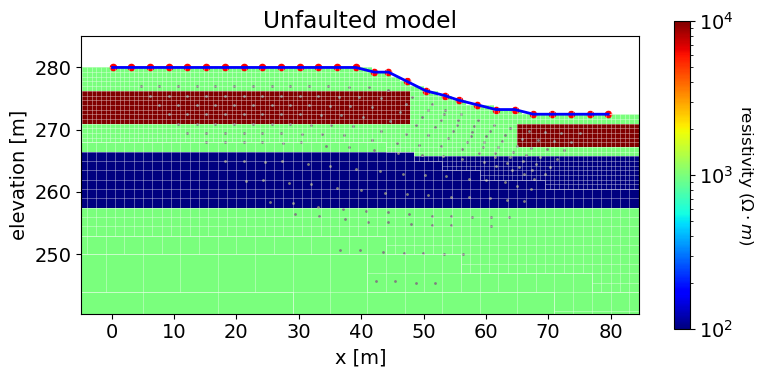

In [ ]:
# # Hypothetical "unfaulted" model
# plot_model_on_survey_and_mesh(mesh=mesh,logresistivity_model=logresistivity_model_unfaulted,
#                               plotting_map=plotting_map, survey=survey, title='Unfaulted model', buffer=5)

## Create Simulation object from the Mesh, the Survey, and the resistivity Map

In [10]:
# Define the DC simulation given the survey setup, the mesh, and the active parts of the mesh
simulation_logresistivity = dc.simulation_2d.Simulation2DNodal(
    mesh=mesh, survey=survey, rhoMap=logresistivity_map
)

# Check simulation
attributes = vars(simulation_logresistivity)
for att, value in attributes.items():
    print(f"{att}: {value}")

_mesh: 
QuadTreeMesh: 11.19% filled

Level : Number of cells               Mesh Extent               Cell Widths    
-----------------------           min     ,     max            min   ,   max   
  3   :       11             ---------------------------   --------------------
  4   :       34          x:     -55.0    ,    137.0          0.75   ,    24.0   
  5   :       61          y:    183.964   ,   279.964         0.75   ,    24.0   
  6   :       125      
  7   :      1153      
  8   :      2284      
-----------------------
Total :      3668      
_survey: Survey(#sources: 52; #data: 215)
_solver: None
_solver_opts: {'is_symmetric': True, 'is_positive_definite': True}
_sensitivity_path: .\sensitivity
_counter: None
_verbose: False
_uuid: ba5db8fd-1f7d-49c8-b929-8035f669abcf
_model: None
_sigma: None
_rho: None
_sigmaMap: None
_rhoMap: ComboMap[InjectActiveCells(3668,3460) * ExpMap(3460,3460)](3668,3460)
_nky: 11
_storeJ: False
_fix_Jmatrix: False
_surface_faces: None
_quad_weigh

## Predict the DC resistivity data from the Simulation and the hypothetical model

In [ ]:
# # Simulate the data from the model
# data_predicted_normalized_volts_unfaulted = simulation_logresistivity.dpred(logresistivity_model_unfaulted)
# # The dpred is always in measured normalized voltages (voltage divided by current, volts/amps, V/A; i.e., resistance).

c:\Users\raulm\anaconda3\envs\basicScience_EOSC556B\Lib\site-packages\simpeg\simulation.py:197: DefaultSolverWarning: Using the default solver: Mumps. 

If you would like to suppress this notification, add 
warnings.filterwarnings('ignore', simpeg.utils.solver_utils.DefaultSolverWarning)
 to your script.
  return get_default_solver(warn=True)


### Plot the predicted data in a pseudosection

array([<Axes: title={'center': 'Unfaulted Model Normalized Voltages'}, ylabel='Pseudo-elevation [m]'>,
       <Axes: title={'center': 'Unfaulted Model Apparent Resistivity'}, xlabel='x [m]', ylabel='Pseudo-elevation [m]'>],
      dtype=object)

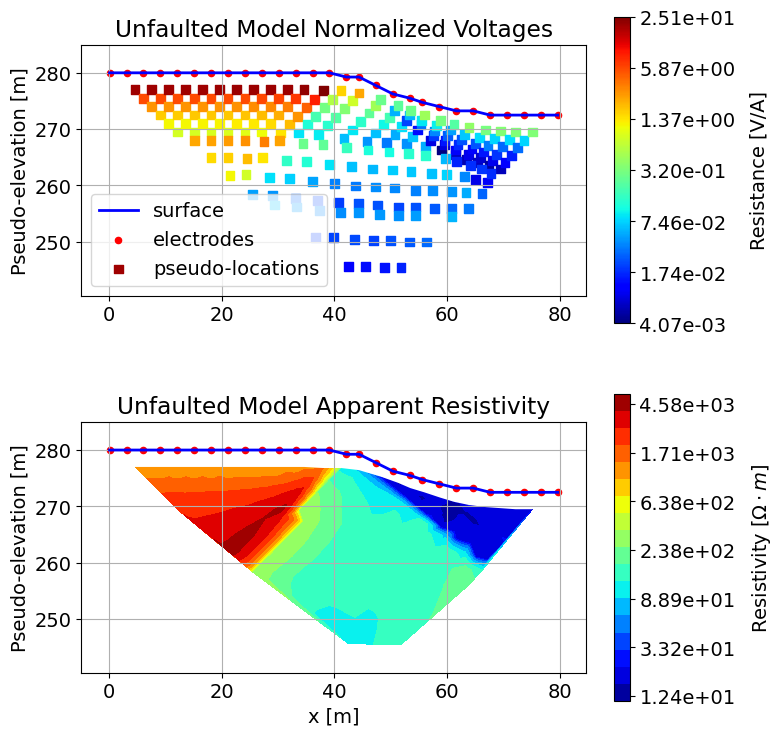

In [ ]:
# plot_normalized_volts_and_apparent_resistivity(data=data_predicted_normalized_volts_unfaulted,
#                                                survey=survey, title="Unfaulted Model")

## Create Data objects

In [ ]:
# # Data from unfaulted model
# data_noisy_unfaulted, uncertainties = create_data_object(data_values=data_predicted_normalized_volts_unfaulted, survey=survey,
#                                           add_noise=True, export=True, filename='data_noisy_unfaulted_quarterspacingmesh')

The Data object was saved to ./outputs/Data_objects/data_noisy_unfaulted_quarterspacingmesh.obs


In [14]:
# Field data
field_data, errors = create_data_object(data_values=field_VI, survey=survey, add_noise=False,
                                        uncertainties=field_error,
                                        export=True, filename='field_data')

The Data object was saved to ./outputs/Data_objects/field_data.obs


# DC Resistivity 2.5D least-squares inversion 

## Import packages

In [15]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import tarfile

from discretize import TreeMesh
from discretize.utils import mkvc, active_from_xyz

from simpeg.utils import model_builder
from simpeg import (
    maps,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
    utils,
)
from simpeg.electromagnetics.static import resistivity as dc
from simpeg.electromagnetics.static.utils.static_utils import (
    plot_pseudosection,
)
from simpeg.utils.io_utils.io_utils_electromagnetics import read_dcip2d_ubc

mpl.rcParams.update({"font.size": 16})
# sphinx_gallery_thumbnail_number = 4

## Define the DC Inverse Problem
The inverse problem is defined by 3 things:

    1) Data Misfit: a measure of how well our recovered model explains the field data
    2) Regularization: constraints placed on the recovered model and a priori information
    3) Optimization: the numerical approach used to solve the inverse problem

In [ ]:
# # Define the data misfit. Here the data misfit is the L2 norm of the weighted
# # residual between the observed data and the data predicted for a given model.
# # Within the data misfit, the residual between predicted and observed data are
# # normalized by the data's standard deviation.
# dmis = data_misfit.L2DataMisfit(data=data_noisy_unfaulted, simulation=simulation_logresistivity)

# # Define the regularization (model objective function)
# referencemod = starting_logresistivity_model
# reg = regularization.WeightedLeastSquares(
#     mesh,
#     active_cells=active_cells,
#     reference_model=referencemod
# )

# reg.reference_model_in_smooth = True  # Reference model in smoothness term

# # Define how the optimization problem is solved. Here we will use an
# # Inexact Gauss Newton approach.
# opt = optimization.InexactGaussNewton(maxIter=40)

# # Here we define the inverse problem that is to be solved
# inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

## Define DC Inversion Directives

Here we define any directives that are carried out during the inversion. This
includes the cooling schedule for the trade-off parameter (beta), stopping
criteria for the inversion and saving inversion results at each iteration.

In [ ]:
# # Apply and update sensitivity weighting as the model updates
# update_sensitivity_weighting = directives.UpdateSensitivityWeights()

# # Defining a starting value for the trade-off parameter (beta) between the data
# # misfit and the regularization.
# starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1e1)

# # Set the rate of reduction in trade-off parameter (beta) each time the
# # the inverse problem is solved. And set the number of Gauss-Newton iterations
# # for each trade-off parameter value.
# beta_schedule = directives.BetaSchedule(coolingFactor=3, coolingRate=3)

# # Options for outputting recovered models and predicted data for each beta.
# save_iteration = directives.SaveOutputEveryIteration(save_txt=True)

# # Setting a stopping criteria for the inversion.
# target_misfit = directives.TargetMisfit(chifact=1)

# # Update preconditioner
# update_jacobi = directives.UpdatePreconditioner()

# directives_list = [
#     update_sensitivity_weighting,
#     starting_beta,
#     beta_schedule,
#     save_iteration,
#     target_misfit,
#     update_jacobi,
# ]

## Create and run the DC Inversion

To define the inversion object, we need to define the inversion problem and
the set of directives. We can then run the inversion.

In [ ]:
# # Here we combine the inverse problem and the set of directives
# dc_inversion = inversion.BaseInversion(inv_prob, directiveList=directives_list)

# # Run inversion
# startingmodel= starting_logresistivity_model
# recovered_resistivity_model = dc_inversion.run(startingmodel)


Running inversion with SimPEG v0.23.0

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation2DNodal problem***
                        


c:\Users\raulm\anaconda3\envs\basicScience_EOSC556B\Lib\site-packages\pymatsolver\solvers.py:415: FutureWarning: In Future pymatsolver v0.4.0, passing a vector of shape (n, 1) to the solve method will return an array with shape (n, 1), instead of always returning a flattened array. This is to be consistent with numpy.linalg.solve broadcasting.
  return self.solve(val)


simpeg.SaveOutputEveryIteration will save your inversion progress as: '###-InversionModel-2025-04-28-14-27.txt'
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  3.26e+03  2.19e+04  0.00e+00  2.19e+04    2.64e+03      0              
   1  3.26e+03  1.10e+04  1.17e+00  1.48e+04    2.78e+02      0              
   2  3.26e+03  1.03e+04  1.37e+00  1.48e+04    2.78e+01      0   Skip BFGS  
   3  1.09e+03  1.02e+04  1.40e+00  1.17e+04    9.17e+02      0   Skip BFGS  
   4  1.09e+03  4.78e+03  4.20e+00  9.35e+03    1.33e+02      0              
   5  1.09e+03  4.46e+03  4.48e+00  9.32e+03    1.36e+01      0   Skip BFGS  
   6  3.62e+02  4.40e+03  4.53e+00  6.04e+03    4.87e+02      0   Skip BFGS  
   7  3.62e+02  1.49e+03  8.98e+00  4.74e+03    1.35e+02      0     

### Export recovered model
So that we don't have to run the inversion each time.

In [ ]:
# save_model_to_txt(model=recovered_resistivity_model, model_filename='recovered_model_unfaulted_quarterspacingmesh')

Directory already exists: ./outputs/Models/
Successfully saved the model to: ./outputs/Models/recovered_model_unfaulted_quarterspacingmesh.txt


### Import model from .txt file

In [ ]:
# recovered_resistivity_model_unfaulted = load_model_from_txt('recovered_model_unfaulted_quarterspacingmesh.txt')

### Plot recovered model

array([<Axes: title={'center': 'Initial Unfaulted Model'}, xlabel='x [m]', ylabel='elevation [m]'>,
       <Axes: title={'center': 'Recovered Unfaulted Model'}, xlabel='x [m]', ylabel='elevation [m]'>],
      dtype=object)

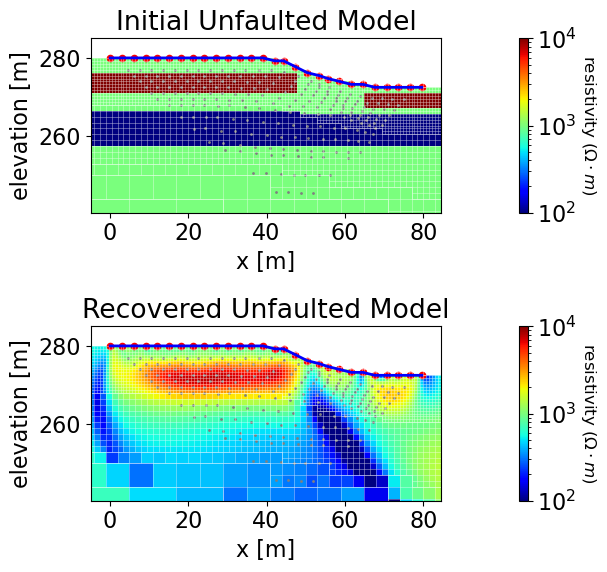

In [ ]:
# plot_initial_and_recovered_models(mesh=mesh, logresmodel_initial=logresistivity_model_unfaulted,
#                                   logresmodel_recovered=recovered_resistivity_model_unfaulted, plotting_map=plotting_map,
#                                   survey=survey, title='Unfaulted Model', model_min=1e+2, model_max=1e+4)

# Now for the faulted model
### Assign materials to different blocks

In [ ]:
# # FAULTED MODEL (fault at x = 42, right side moves down by 2m)
# logresistivity_model_faulted = SAND_LOGRESISTIVITY *np.ones(number_of_active_cells)

# ind_gravel1_faulted_left = model_builder.get_indices_block(np.r_[-40,271],np.r_[42,276.5],mesh.cell_centers[active_cells, :])
# ind_gravel1_faulted_right = model_builder.get_indices_block(np.r_[42,269],np.r_[48,274.5],mesh.cell_centers[active_cells, :])
# ind_gravel2_faulted = model_builder.get_indices_block(np.r_[65,265],np.r_[120,269],mesh.cell_centers[active_cells, :])
# ind_mud_faulted_left = model_builder.get_indices_block(np.r_[-40,258],np.r_[42,266],mesh.cell_centers[active_cells,:])
# ind_mud_faulted_right = model_builder.get_indices_block(np.r_[42,256],np.r_[120,264],mesh.cell_centers[active_cells,:])

# logresistivity_model_faulted[ind_gravel1_faulted_left] = GRAVEL_LOGRESISTIVITY
# logresistivity_model_faulted[ind_gravel1_faulted_right] = GRAVEL_LOGRESISTIVITY
# logresistivity_model_faulted[ind_gravel2_faulted] = GRAVEL_LOGRESISTIVITY
# logresistivity_model_faulted[ind_mud_faulted_left] = MUD_LOGRESISTIVITY
# logresistivity_model_faulted[ind_mud_faulted_right] = MUD_LOGRESISTIVITY

### Plot the faulted model

<Axes: title={'center': 'Faulted model'}, xlabel='x [m]', ylabel='elevation [m]'>

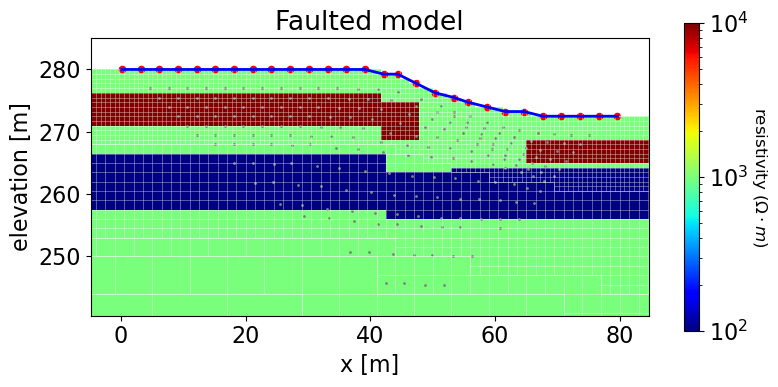

In [ ]:
# # Hypothetical "faulted model"
# plot_model_on_survey_and_mesh(mesh=mesh, logresistivity_model=logresistivity_model_faulted,
#                               plotting_map=plotting_map, survey=survey, title='Faulted model')

### Simulate the faulted data

In [ ]:
# data_predicted_normalized_volts_faulted = simulation_logresistivity.dpred(logresistivity_model_faulted)

c:\Users\raulm\anaconda3\envs\basicScience_EOSC556B\Lib\site-packages\simpeg\simulation.py:197: DefaultSolverWarning: Using the default solver: Mumps. 

If you would like to suppress this notification, add 
warnings.filterwarnings('ignore', simpeg.utils.solver_utils.DefaultSolverWarning)
 to your script.
  return get_default_solver(warn=True)


### Plot the simulated data in a pseudo-section

array([<Axes: title={'center': 'Faulted Model Normalized Voltages'}, ylabel='Pseudo-elevation [m]'>,
       <Axes: title={'center': 'Faulted Model Apparent Resistivity'}, xlabel='x [m]', ylabel='Pseudo-elevation [m]'>],
      dtype=object)

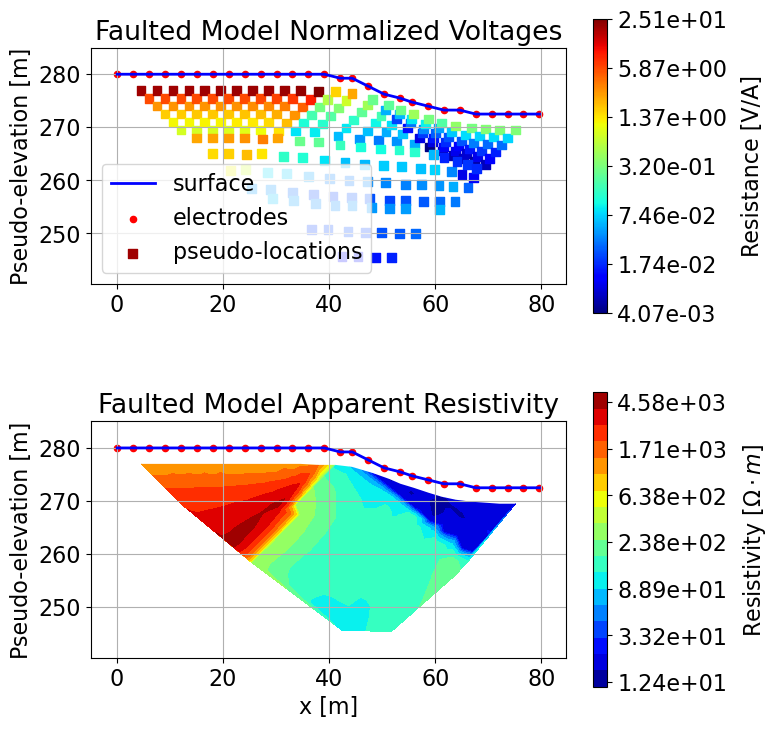

In [ ]:
# plot_normalized_volts_and_apparent_resistivity(data=data_predicted_normalized_volts_unfaulted,
#                                                survey=survey, title="Faulted Model")

### Create Data object for faulted model

In [ ]:
# data_noisy_faulted, _ = create_data_object(data_values=data_predicted_normalized_volts_faulted, survey=survey,
#                                         add_noise=True, export=True, filename='data_noisy_faulted_quarterspacingmesh')

The Data object was saved to ./outputs/Data_objects/data_noisy_faulted_quarterspacingmesh.obs


### Update the data_misfit of the inverse_problem

In [ ]:
# # Define the data misfit. Here the data misfit is the L2 norm of the weighted
# # residual between the observed data and the data predicted for a given model.
# # Within the data misfit, the residual between predicted and observed data are
# # normalized by the data's standard deviation.
# dmis_faulted = data_misfit.L2DataMisfit(data=data_noisy_faulted, simulation=simulation_logresistivity)

# # Define the regularization (model objective function)
# referencemod = starting_logresistivity_model
# reg = regularization.WeightedLeastSquares(
#     mesh,
#     active_cells=active_cells,
#     reference_model=referencemod
# )

# reg.reference_model_in_smooth = True  # Reference model in smoothness term

# # Define how the optimization problem is solved. Here we will use an
# # Inexact Gauss Newton approach.
# opt = optimization.InexactGaussNewton(maxIter=40)

# # Here we define the inverse problem that is to be solved
# inv_prob_faulted = inverse_problem.BaseInvProblem(dmis_faulted, reg, opt)

### Using the same directives, run the inverse problem

In [ ]:
# # Apply and update sensitivity weighting as the model updates
# update_sensitivity_weighting = directives.UpdateSensitivityWeights()

# # Defining a starting value for the trade-off parameter (beta) between the data
# # misfit and the regularization.
# starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1e1)

# # Set the rate of reduction in trade-off parameter (beta) each time the
# # the inverse problem is solved. And set the number of Gauss-Newton iterations
# # for each trade-off parameter value.
# beta_schedule = directives.BetaSchedule(coolingFactor=3, coolingRate=3)

# # Options for outputting recovered models and predicted data for each beta.
# save_iteration = directives.SaveOutputEveryIteration(save_txt=True)

# # Setting a stopping criteria for the inversion.
# target_misfit = directives.TargetMisfit(chifact=1)

# # Update preconditioner
# update_jacobi = directives.UpdatePreconditioner()

# directives_list = [
#     update_sensitivity_weighting,
#     starting_beta,
#     beta_schedule,
#     save_iteration,
#     target_misfit,
#     update_jacobi,
# ]

In [ ]:
# # Here we combine the inverse problem and the set of directives
# dc_inversion_faulted = inversion.BaseInversion(inv_prob_faulted, directiveList=directives_list)

# # Run inversion
# startingmodel= starting_logresistivity_model
# recovered_resistivity_model_faulted = dc_inversion_faulted.run(startingmodel)


Running inversion with SimPEG v0.23.0

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation2DNodal problem***
                        


c:\Users\raulm\anaconda3\envs\basicScience_EOSC556B\Lib\site-packages\pymatsolver\solvers.py:415: FutureWarning: In Future pymatsolver v0.4.0, passing a vector of shape (n, 1) to the solve method will return an array with shape (n, 1), instead of always returning a flattened array. This is to be consistent with numpy.linalg.solve broadcasting.
  return self.solve(val)


simpeg.SaveOutputEveryIteration will save your inversion progress as: '###-InversionModel-2025-04-28-14-31.txt'
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  3.76e+03  2.18e+04  0.00e+00  2.18e+04    2.68e+03      0              
   1  3.76e+03  1.13e+04  1.00e+00  1.51e+04    2.75e+02      0              
   2  3.76e+03  1.06e+04  1.16e+00  1.50e+04    2.70e+01      0   Skip BFGS  
   3  1.25e+03  1.05e+04  1.18e+00  1.20e+04    9.73e+02      0   Skip BFGS  
   4  1.25e+03  5.02e+03  3.67e+00  9.61e+03    1.30e+02      0              
   5  1.25e+03  4.68e+03  3.92e+00  9.58e+03    1.72e+01      0   Skip BFGS  
   6  4.17e+02  4.62e+03  3.96e+00  6.28e+03    5.19e+02      0   Skip BFGS  
   7  4.17e+02  1.57e+03  8.01e+00  4.91e+03    1.30e+02      0     

### Save and then import the recovered model

In [ ]:
# save_model_to_txt(model=recovered_resistivity_model_faulted, model_filename='recovered_model_faulted_quarterspacingmesh')

Directory already exists: ./outputs/Models/
Successfully saved the model to: ./outputs/Models/recovered_model_faulted_quarterspacingmesh.txt


In [ ]:
# recovered_resistivity_model_faulted = load_model_from_txt(file_to_import='recovered_model_faulted_quarterspacingmesh.txt')

### Plot recovered model

array([<Axes: title={'center': 'Initial Faulted Model'}, xlabel='x [m]', ylabel='elevation [m]'>,
       <Axes: title={'center': 'Recovered Faulted Model'}, xlabel='x [m]', ylabel='elevation [m]'>],
      dtype=object)

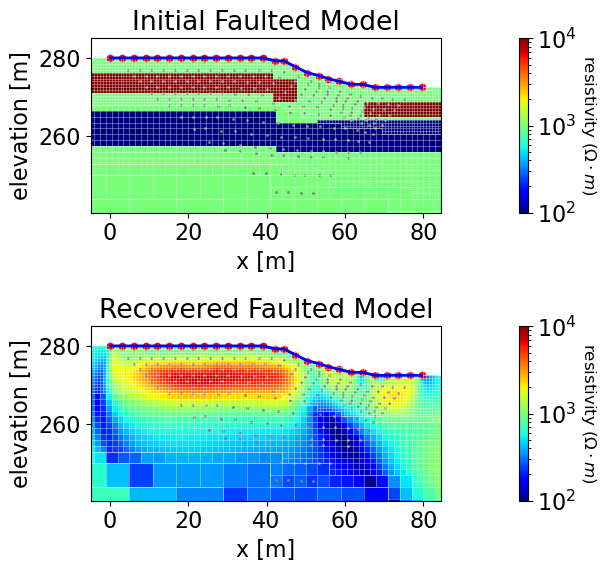

In [ ]:
# plot_initial_and_recovered_models(mesh=mesh, logresmodel_initial=logresistivity_model_faulted,
#                                   logresmodel_recovered=recovered_resistivity_model_faulted, plotting_map=plotting_map,
#                                   survey=survey, title='Faulted Model', model_min=1e+2, model_max=1e+4)

# And now for the field data
### Plot field data

array([<Axes: title={'center': 'Field Data Normalized Voltages'}, ylabel='Pseudo-elevation [m]'>,
       <Axes: title={'center': 'Field Data Apparent Resistivity'}, xlabel='x [m]', ylabel='Pseudo-elevation [m]'>],
      dtype=object)

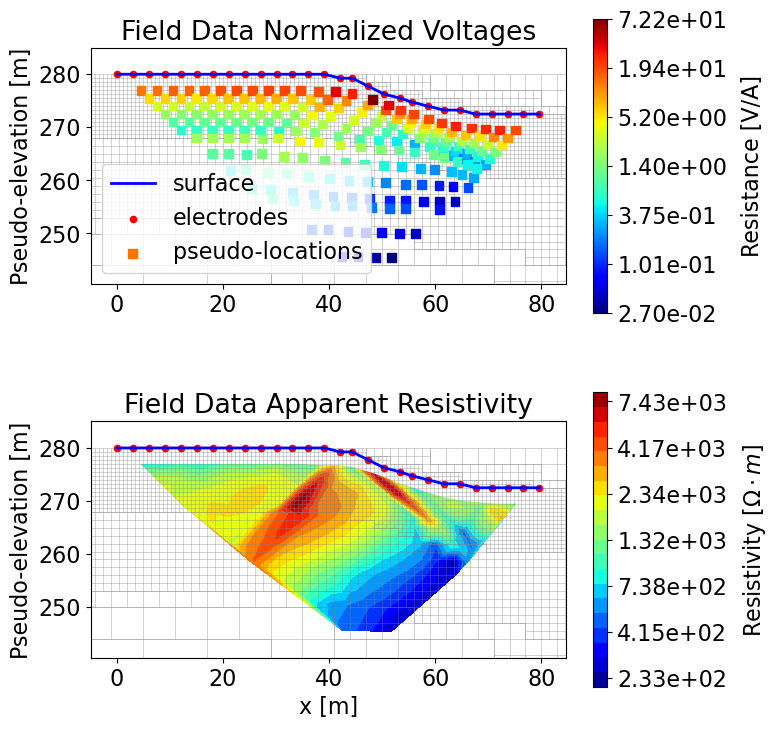

In [44]:
plot_normalized_volts_and_apparent_resistivity(data=field_data.dobs, survey=survey, mesh=mesh, title='Field Data')

### Define the inverse problem for the field data

In [34]:
# Define the data misfit. Here the data misfit is the L2 norm of the weighted
# residual between the observed data and the data predicted for a given model.
# Within the data misfit, the residual between predicted and observed data are
# normalized by the data's standard deviation.
dmis_field = data_misfit.L2DataMisfit(data=field_data, simulation=simulation_logresistivity)

# Define the regularization (model objective function)
# Set referencemod to the mean apparent log-resistivity of the field data. 
referencemod = np.ceil(np.mean(np.log(apparent_resistivity_from_voltage(survey,field_VI))) * np.ones(number_of_active_cells))
reg = regularization.WeightedLeastSquares(
    mesh,
    active_cells=active_cells,
    reference_model=referencemod
)

reg.reference_model_in_smooth = True  # Reference model in smoothness term

# Define how the optimization problem is solved. Here we will use an
# Inexact Gauss Newton approach.
opt = optimization.InexactGaussNewton(maxIter=40)

# Here we define the inverse problem that is to be solved
inv_prob_field = inverse_problem.BaseInvProblem(dmis_field, reg, opt)

### Using the same directives, run the inverse problem for the field data

In [35]:
# Apply and update sensitivity weighting as the model updates
update_sensitivity_weighting = directives.UpdateSensitivityWeights()

# Defining a starting value for the trade-off parameter (beta) between the data
# misfit and the regularization.
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1e1)

# Set the rate of reduction in trade-off parameter (beta) each time the
# the inverse problem is solved. And set the number of Gauss-Newton iterations
# for each trade-off parameter value.
beta_schedule = directives.BetaSchedule(coolingFactor=3, coolingRate=3)

# Options for outputting recovered models and predicted data for each beta.
save_iteration = directives.SaveOutputEveryIteration(save_txt=True)

# Setting a stopping criteria for the inversion.
target_misfit = directives.TargetMisfit(chifact=1)

# Update preconditioner
update_jacobi = directives.UpdatePreconditioner()

directives_list = [
    update_sensitivity_weighting,
    starting_beta,
    beta_schedule,
    save_iteration,
    target_misfit,
    update_jacobi,
]

In [36]:
# Here we combine the inverse problem and the set of directives
dc_inversion_field = inversion.BaseInversion(inv_prob_field, directiveList=directives_list)

# Run inversion
startingmodel= referencemod
recovered_resistivity_model_field = dc_inversion_field.run(startingmodel)


Running inversion with SimPEG v0.23.0

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation2DNodal problem***
                        


c:\Users\raulm\anaconda3\envs\basicScience_EOSC556B\Lib\site-packages\simpeg\simulation.py:197: DefaultSolverWarning: Using the default solver: Mumps. 

If you would like to suppress this notification, add 
warnings.filterwarnings('ignore', simpeg.utils.solver_utils.DefaultSolverWarning)
 to your script.
  return get_default_solver(warn=True)


simpeg.SaveOutputEveryIteration will save your inversion progress as: '###-InversionModel-2025-04-28-14-36.txt'


c:\Users\raulm\anaconda3\envs\basicScience_EOSC556B\Lib\site-packages\pymatsolver\solvers.py:415: FutureWarning: In Future pymatsolver v0.4.0, passing a vector of shape (n, 1) to the solve method will return an array with shape (n, 1), instead of always returning a flattened array. This is to be consistent with numpy.linalg.solve broadcasting.
  return self.solve(val)


model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.27e+04  3.87e+05  0.00e+00  3.87e+05    3.12e+04      0              
   1  1.27e+04  2.93e+05  3.06e+00  3.32e+05    3.47e+03      0              
   2  1.27e+04  2.97e+05  2.63e+00  3.30e+05    7.22e+02      0              
   3  4.25e+03  2.94e+05  2.85e+00  3.06e+05    1.15e+04      0              
   4  4.25e+03  2.41e+05  1.07e+01  2.86e+05    2.09e+03      0              
   5  4.25e+03  2.43e+05  9.82e+00  2.85e+05    9.27e+02      1              
   6  1.42e+03  2.43e+05  9.77e+00  2.57e+05    7.01e+03      1              
   7  1.42e+03  2.29e+05  1.60e+01  2.51e+05    3.60e+03      1              
   8  1.42e+03  2.25e+05  1.59e+01  2.48e+05    2.65e+03      2              
   9  4.72e+02  2.16e+05

c:\Users\raulm\anaconda3\envs\basicScience_EOSC556B\Lib\site-packages\simpeg\maps\_property_maps.py:48: RuntimeWarning: overflow encountered in exp
  return np.exp(mkvc(m))


  34  7.20e-02  1.67e+05  8.13e+02  1.67e+05    1.47e+03      4              
  35  7.20e-02  1.66e+05  9.89e+02  1.66e+05    1.16e+03      2              
  36  2.40e-02  1.66e+05  1.20e+03  1.66e+05    1.14e+03      3              
  37  2.40e-02  1.66e+05  1.20e+03  1.66e+05    1.17e+03      6              
  38  2.40e-02  1.66e+05  1.22e+03  1.66e+05    1.16e+03      4   Skip BFGS  
  39  8.00e-03  1.65e+05  1.24e+03  1.65e+05    1.03e+03      2   Skip BFGS  


c:\Users\raulm\anaconda3\envs\basicScience_EOSC556B\Lib\site-packages\simpeg\maps\_property_maps.py:141: RuntimeWarning: divide by zero encountered in divide
  return 1.0 / mkvc(m)


  40  8.00e-03  1.65e+05  1.25e+03  1.65e+05    1.04e+03      7              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 5.1429e+01 <= tolF*(1+|f0|) = 3.8663e+04
1 : |xc-x_last| = 3.6666e+01 <= tolX*(1+|x0|) = 4.7157e+01
0 : |proj(x-g)-x|    = 1.0422e+03 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 1.0422e+03 <= 1e3*eps       = 1.0000e-02
1 : maxIter   =      40    <= iter          =     40
------------------------- DONE! -------------------------


### Save and then import the model recovered from field data

In [37]:
save_model_to_txt(model=recovered_resistivity_model_field, model_filename='recovered_model_field_quarterspacingmesh')

Directory already exists: ./outputs/Models/
Successfully saved the model to: ./outputs/Models/recovered_model_field_quarterspacingmesh.txt


In [38]:
recovered_resistivity_model_field = load_model_from_txt(file_to_import='recovered_model_field_quarterspacingmesh.txt')

### Plot the model recovered from the field

<Axes: title={'center': 'Model recovered from Field Data'}, xlabel='x [m]', ylabel='elevation [m]'>

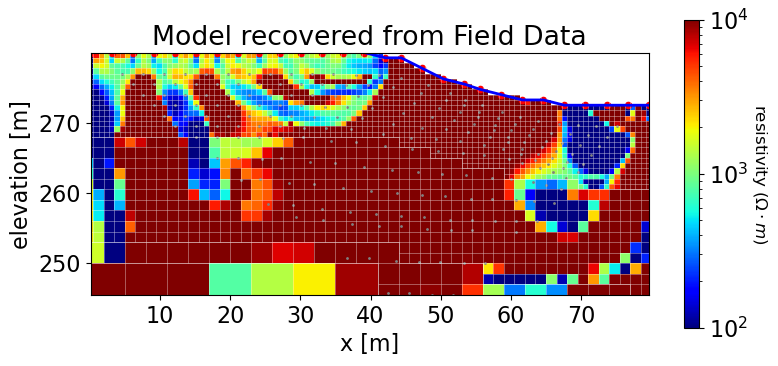

In [39]:
plot_model_on_survey_and_mesh(mesh=mesh, logresistivity_model=recovered_resistivity_model_field, plotting_map=plotting_map,
                              survey=survey, title="Model recovered from Field Data", model_min=1e+2, model_max=1e+4,buffer=0)

In [40]:
dpred = inv_prob_field.dpred
dobs = field_data.dobs
std = field_data.standard_deviation

In [41]:
residual = dpred - dobs
relative_misfits = (residual/np.abs(dobs)) # Probably better to look at
# misfits = ((1/std)* residual)**2
noisy_data_points = np.abs(relative_misfits) > 0.95
noisy_data_points

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False,  True,  True, False,
        True, False,  True,  True,  True, False, False,  True,  True,
        True, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [42]:
rms = np.sqrt(np.sum(relative_misfits**2)/relative_misfits.size)*100
rms

np.float64(71.17808751591609)

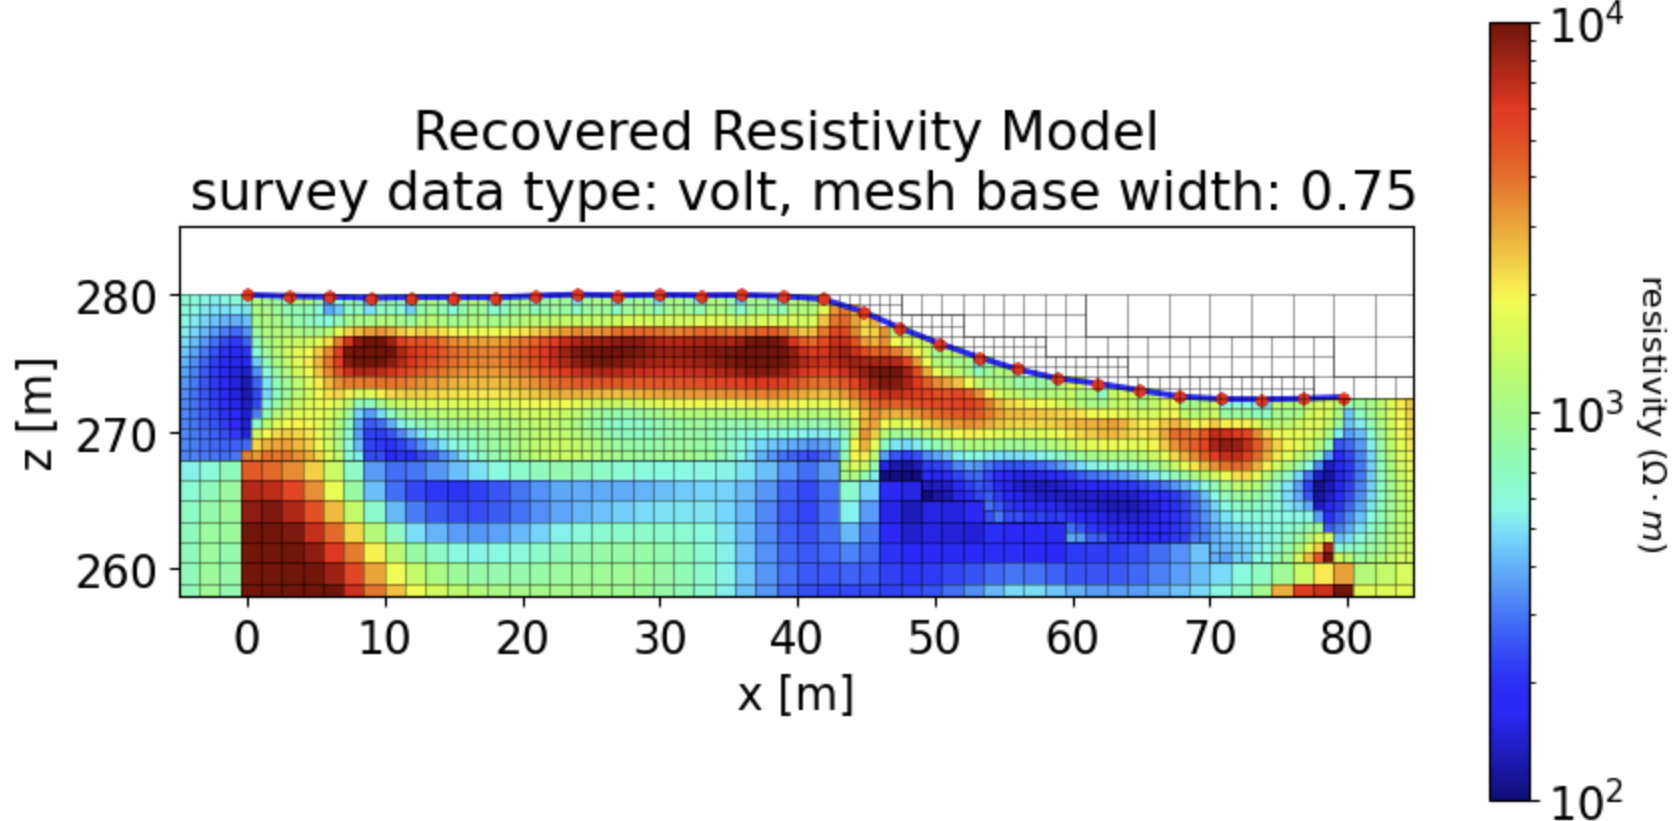
Field data:

With noise

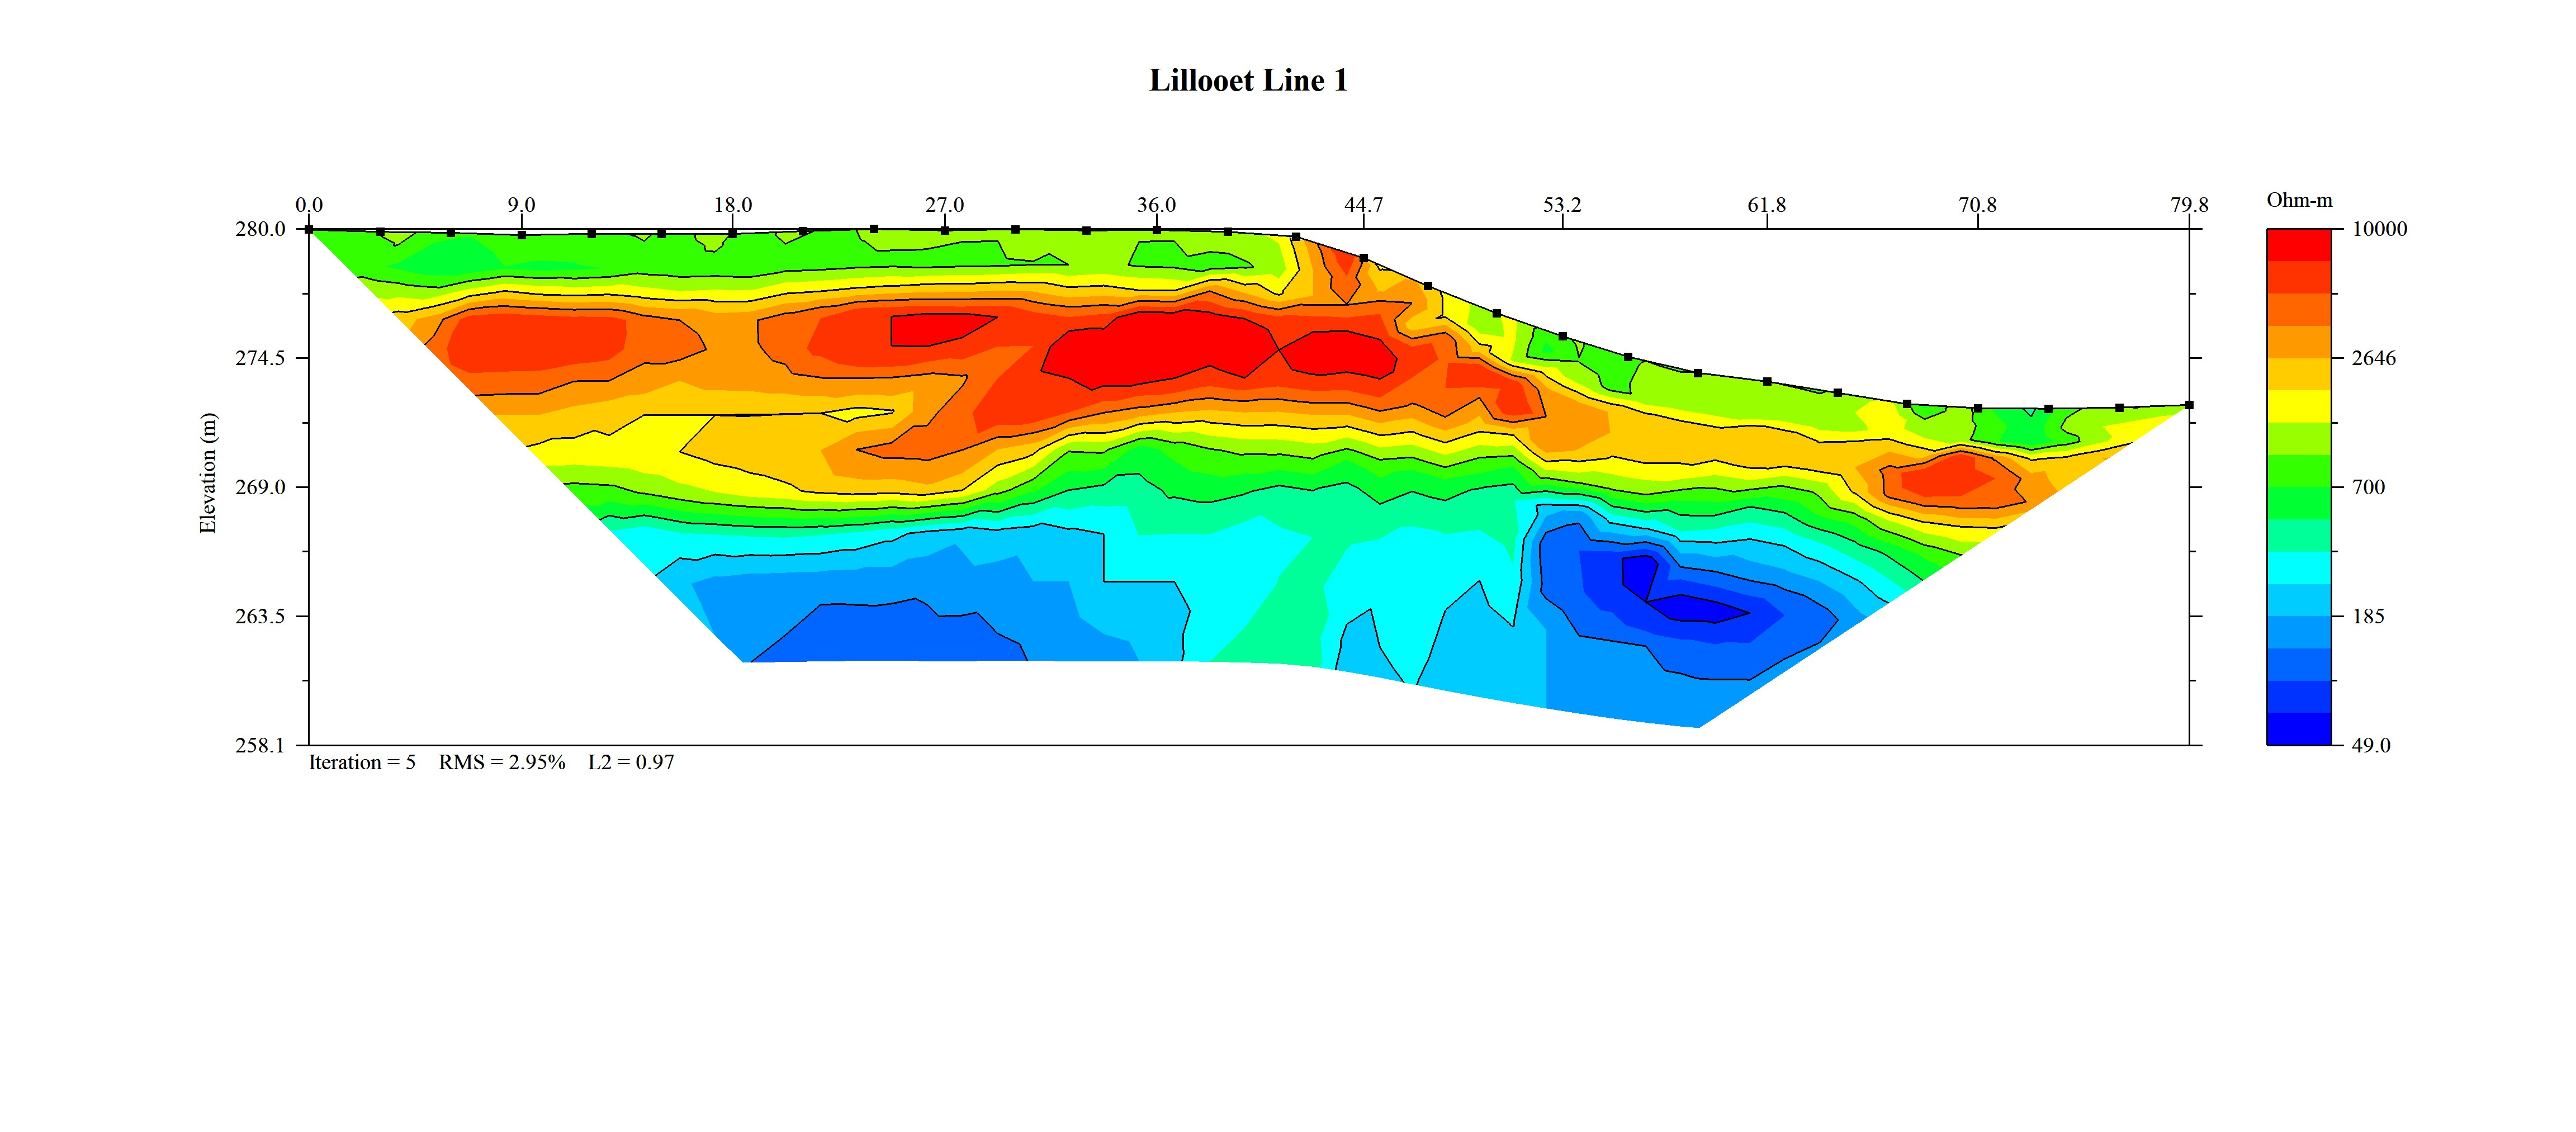

Noisy data points filtered out

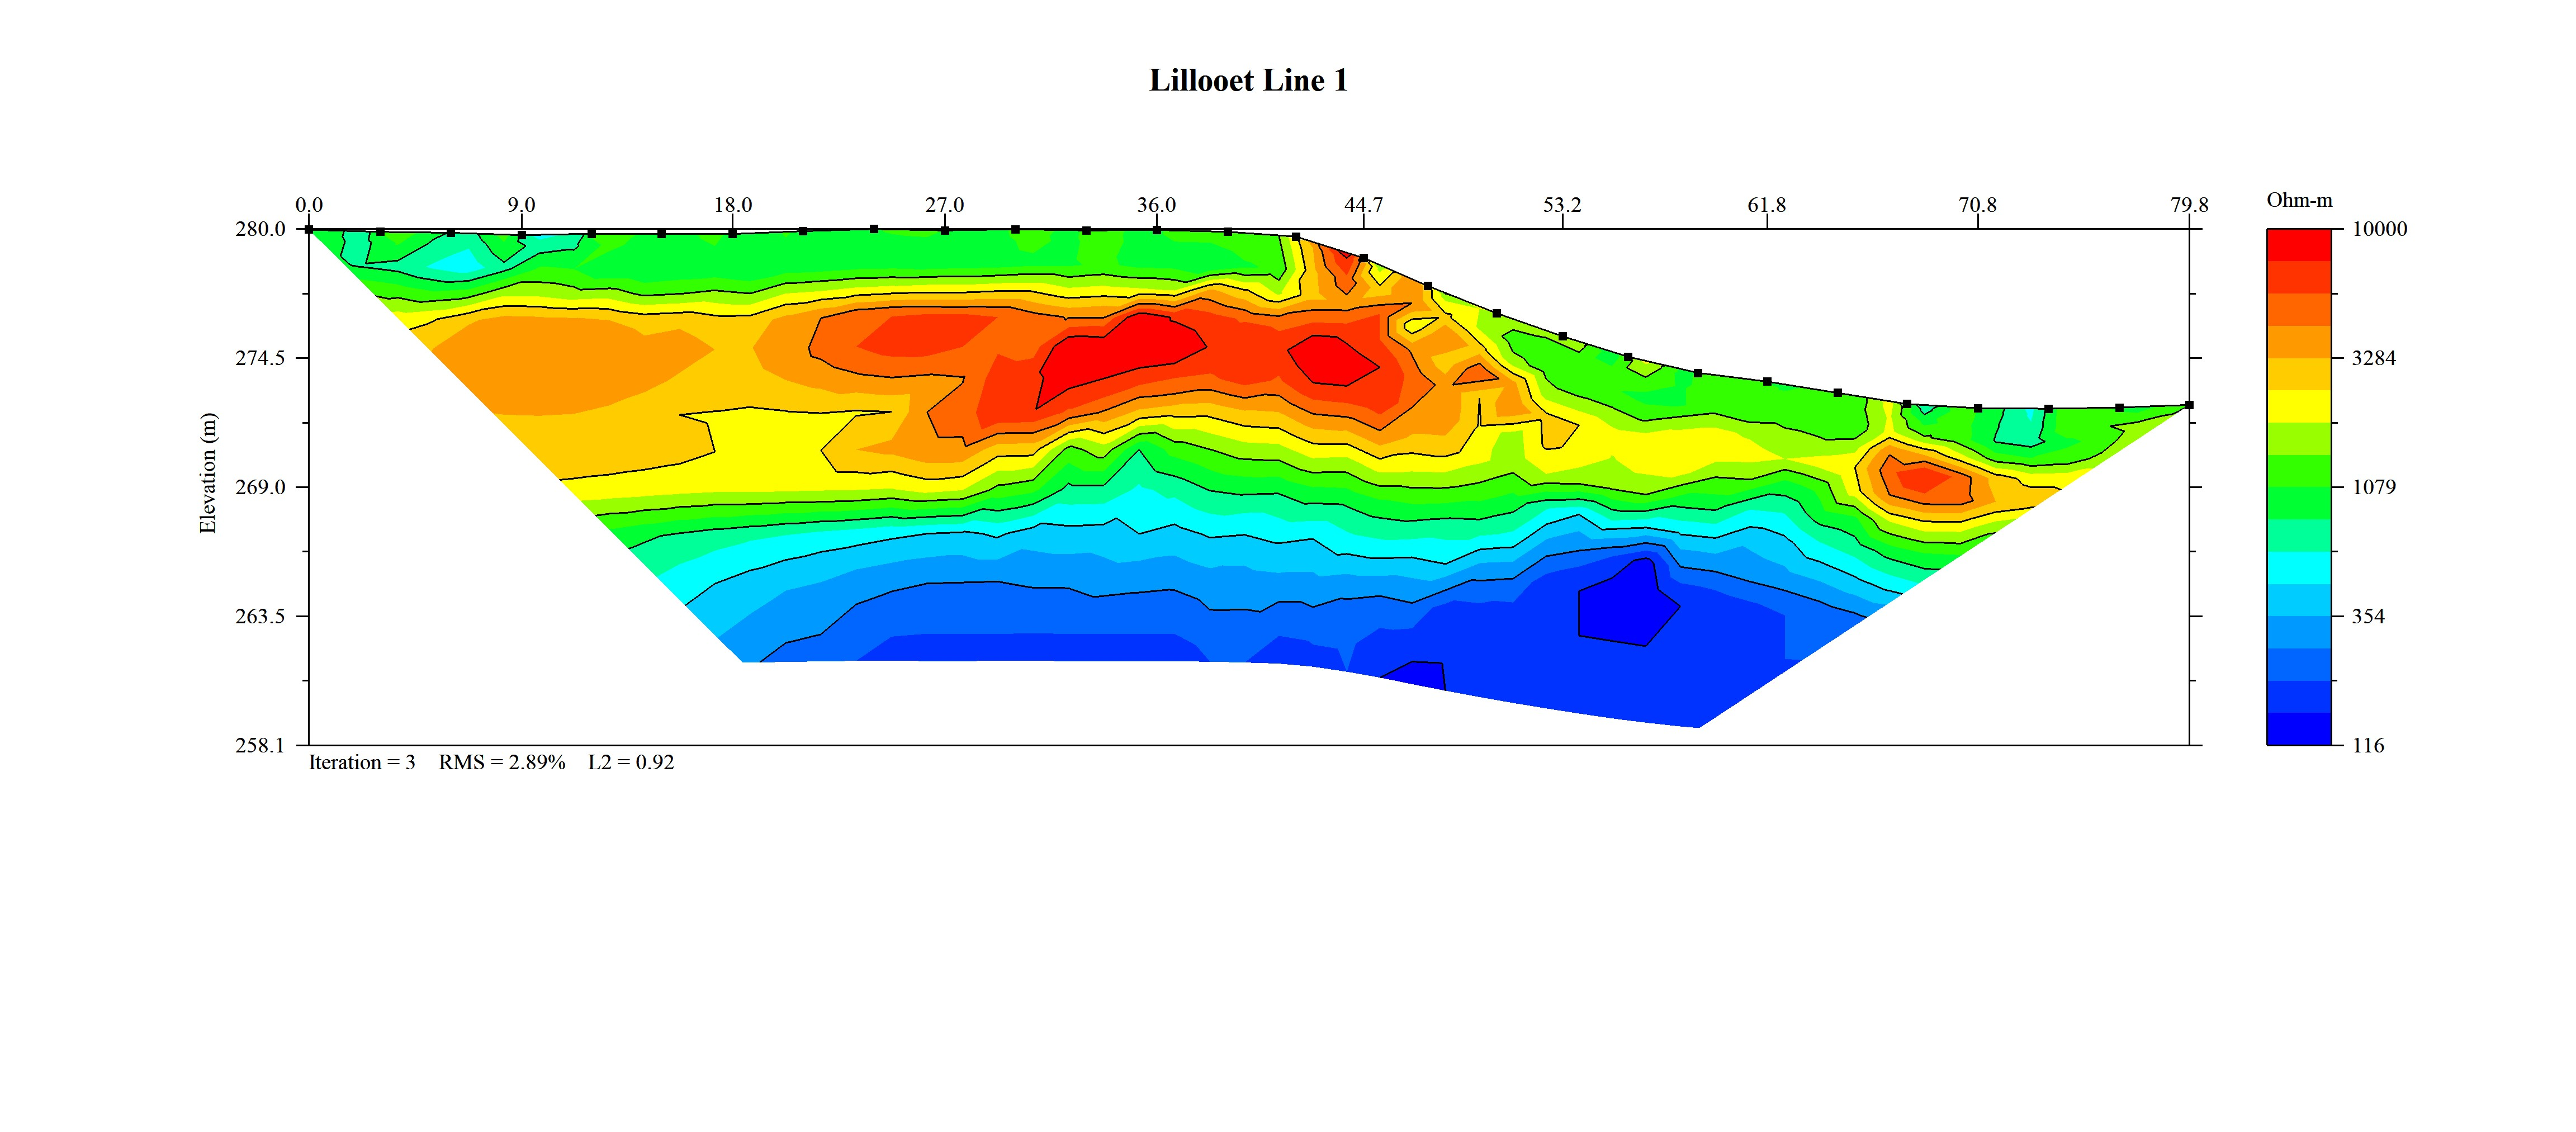

## Calculate RMS error
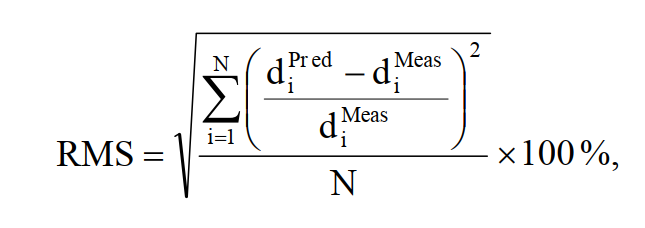

## L2-Norm and Normalized L2-Norm
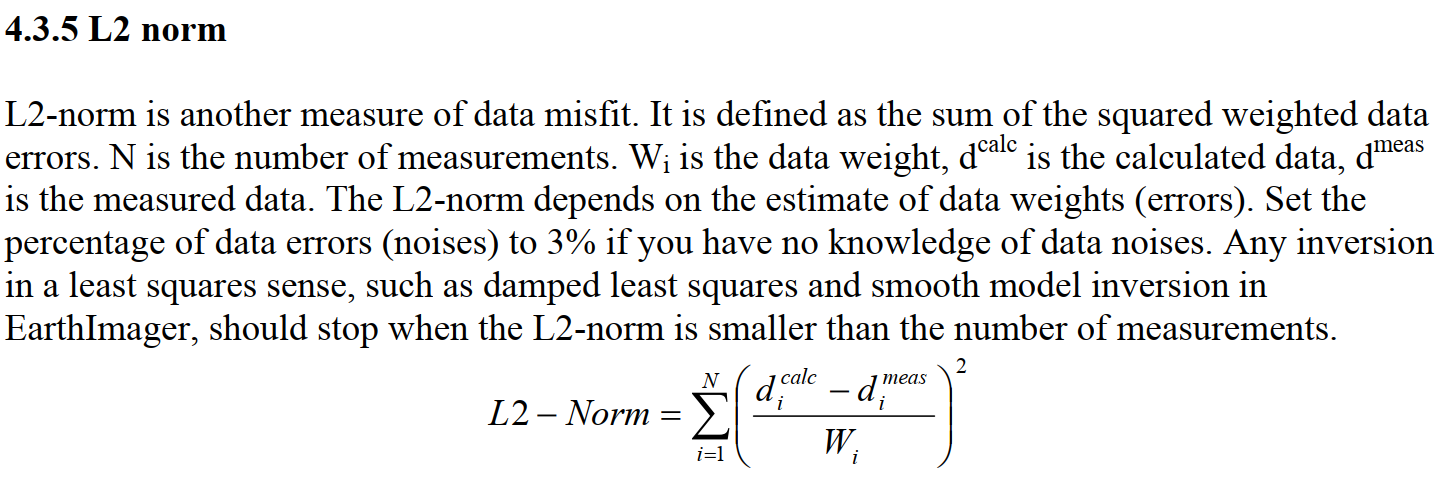
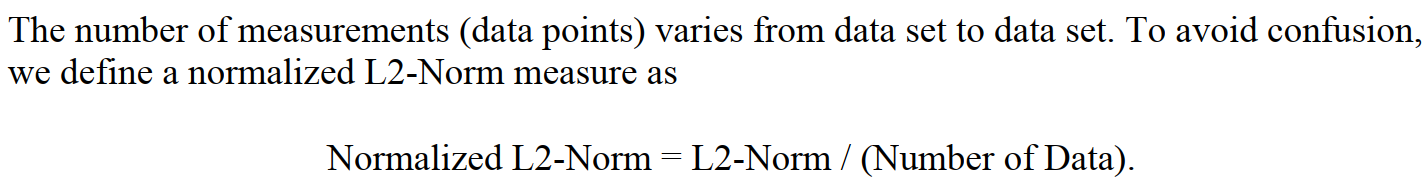

In [43]:
# dpred_recovered = simulation_logresistivity.dpred(recovered_resistivity_model)
# apparent_resistivities_recovered = apparent_resistivity_from_voltage(survey, dpred_recovered)